In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [2]:
beds_folder = '/Users/mariyajeeranwala/Desktop/ikea/beds'

sofa_folder = '/Users/mariyajeeranwala/Desktop/ikea/sofa'

chairs_folder = '/Users/mariyajeeranwala/Desktop/ikea/chairs'

tables_folder = '/Users/mariyajeeranwala/Desktop/ikea/tables'

shelving_folder = '/Users/mariyajeeranwala/Desktop/ikea/shelving'

wadrobe_folder = '/Users/mariyajeeranwala/Desktop/ikea/wadrobe'

In [3]:
# Function to load images from a folder and create a DataFrame
def load_images(folder_path):
    image_paths = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:  # Check if image was loaded successfully
                image_paths.append(image_path)
    return pd.DataFrame({'image_path': image_paths})

# Load images from each folder
beds_df = load_images(beds_folder)
sofa_df = load_images(sofa_folder)
chairs_df = load_images(chairs_folder)
tables_df = load_images(tables_folder)
shelving_df = load_images(shelving_folder)
wadrobe_df = load_images(wadrobe_folder)


# Combine DataFrames
combined_df = pd.concat([beds_df, sofa_df, chairs_df, tables_df, shelving_df, wadrobe_df])

Premature end of JPEG file


In [258]:
print(combined_df.shape)

(11373, 1)


In [4]:
# Remove duplicate images based on image content
def remove_duplicates(df):
    image_hashes = []
    unique_df = pd.DataFrame()
    for index, row in df.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        image_hash = hash(image.tobytes())
        if image_hash not in image_hashes:
            image_hashes.append(image_hash)
            unique_df = pd.concat([unique_df, row.to_frame().T], ignore_index=True)
    return unique_df

# Remove duplicates from the combined DataFrame
combined_df = remove_duplicates(combined_df)


Premature end of JPEG file


In [5]:
print(combined_df.shape)

(8812, 1)


In [ ]:
def process_image(image_path, image_size=(80, 80)):
    try:
        img = Image.open(image_path).convert('RGB')  # Open and convert to RGB
        # Resize the image
        img = img.resize(image_size)
        img_array = np.array(img)  # Convert to a numpy array
        img_array = img_array.flatten()  # Flatten the 3D image to 1D
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
combined_df['processed_image'] = combined_df['image_path'].apply(process_image)    

In [ ]:
def color_edge_detection(image, image_size=(80,80)):
  try:
    img=img.resize(image_size)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 150)
    img_array=edges.flatten()


    return img_array

  except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


combined_df['processed_edges'] = combined_df['image_path'].apply(process_image)


In [ ]:
combined_df = combined_df.applymap(lambda x: [x] if isinstance(x, int) else x)

In [ ]:
from transformers import AutoProcessor, AutoImageProcessor, ViTMAEModel
import torch
import torch.nn as nn

# Define the FeatureExtractor class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")

    def forward(self, inputs):
        inputs.pop('image_name', None)
        outputs = self.model(**inputs)
        return torch.sum(outputs.last_hidden_state, dim=1)

# Load the processor
processor = AutoProcessor.from_pretrained("facebook/vit-mae-base")

# Function to process each image and extract features
def extract_features_from_df(row, feature_extractor, processor):
    try:
        # Load the image from the path
        image = Image.open(row['image_path'])

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")

        # Extract features
        with torch.no_grad():  # For inference
            features = feature_extractor(inputs)

        # Convert tensor to list (or numpy array) if you want to store it in a DataFrame
        return features.squeeze().tolist()

    except Exception as e:
        print(f"Error processing image {row['image_path']}: {e}")
        return None

# Example DataFrame with image paths
df = pd.DataFrame(combined_df['image_path'])
# Instantiate the FeatureExtractor
feature_extractor = FeatureExtractor()

# Apply the feature extraction to each row
df['features'] = df.apply(lambda row: extract_features_from_df(row, feature_extractor, processor), axis=1)

# Check the output DataFrame with extracted features
print(df.head())

In [ ]:
# Drop rows where 'features' column contains NaN or None
df = df.dropna(subset=['features'])

# Ensure 'features' column contains lists (or valid feature data)
df = df[df['features'].apply(lambda x: isinstance(x, list))]

# Convert the list of features into a new DataFrame (expand each list element into its own column)
features_df = pd.DataFrame(df['features'].to_list())

# Reset the index of both DataFrames to ensure unique indices
df = df.reset_index(drop=True)
features_df = features_df.reset_index(drop=True)

# Concatenate both DataFrames along the columns
df = pd.concat([df, features_df], axis=1)

# Check the updated DataFrame
print(df.head())


In [6]:
import numpy as np
import pandas as pd

In [7]:
features_df=pd.read_csv('/Users/mariyajeeranwala/Desktop/ikea/features_df.csv')
df=pd.read_csv('/Users/mariyajeeranwala/Desktop/ikea/features_df.csv')

In [4]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])
df.columns = df.columns.astype(str)

In [512]:
df1 = df.drop(columns=['cluster'])

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Keep components that explain 95% of the variance
principal_components = pca.fit_transform(df)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data = principal_components)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[0.91816356 0.01863835 0.01282247 0.00847042]


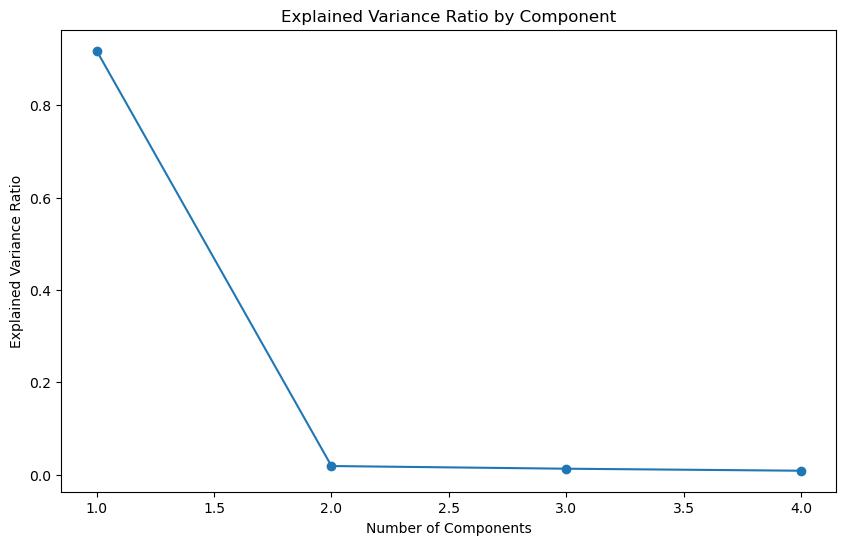

In [6]:
# Visualize   the explained variance ratio
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Component')
plt.show()

In [6]:
principal_df.shape

(8483, 4)

In [7]:
principal_df.describe()

,0,1,2,3
count,8.483000e+03,8.483000e+03,8.483000e+03,8.483000e+03
mean,-1.262550e-12,-5.575118e-14,-1.372337e-14,-1.519756e-14
std,5.391361e+02,7.681429e+01,6.371243e+01,5.178344e+01
min,-2.039960e+03,-2.724464e+02,-3.707500e+02,-2.949342e+02
25%,-3.982310e+02,-5.793451e+01,-4.525542e+01,-2.940709e+01
50%,1.241870e+02,-2.045654e+00,3.076175e+00,-4.944913e+00
75%,4.466897e+02,5.710663e+01,4.852783e+01,2.026418e+01
max,8.220050e+02,2.345171e+02,2.383134e+02,5.525545e+02


In [8]:
principal_df.columns = principal_df.columns.astype(str)

In [9]:
principal_df1=principal_df[['0','1','2','3']]

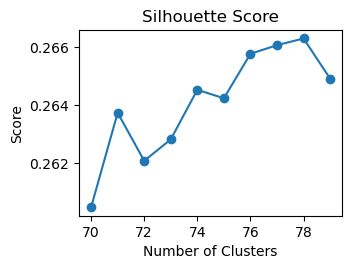

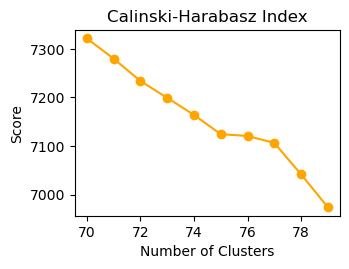

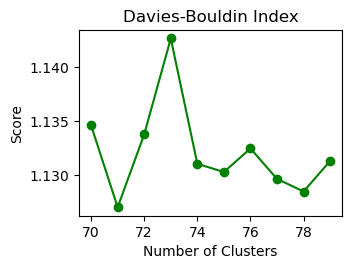

In [441]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(70,80)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    principal_df['cluster'] = kmeans.fit_predict(principal_df1)
    
    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)


import matplotlib.pyplot as plt


plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()



In [442]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=77, init='k-means++', random_state=42)
principal_df['cluster'] = kmeans.fit_predict(principal_df1)

In [443]:
from collections import Counter

cluster_sizes = Counter(principal_df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 250:
        print(f"Cluster {cluster_label} has {size} points")

Cluster 28 has 10 points
Cluster 29 has 290 points


In [444]:
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.26607636218534875
7106.248013494146
1.129671856638038


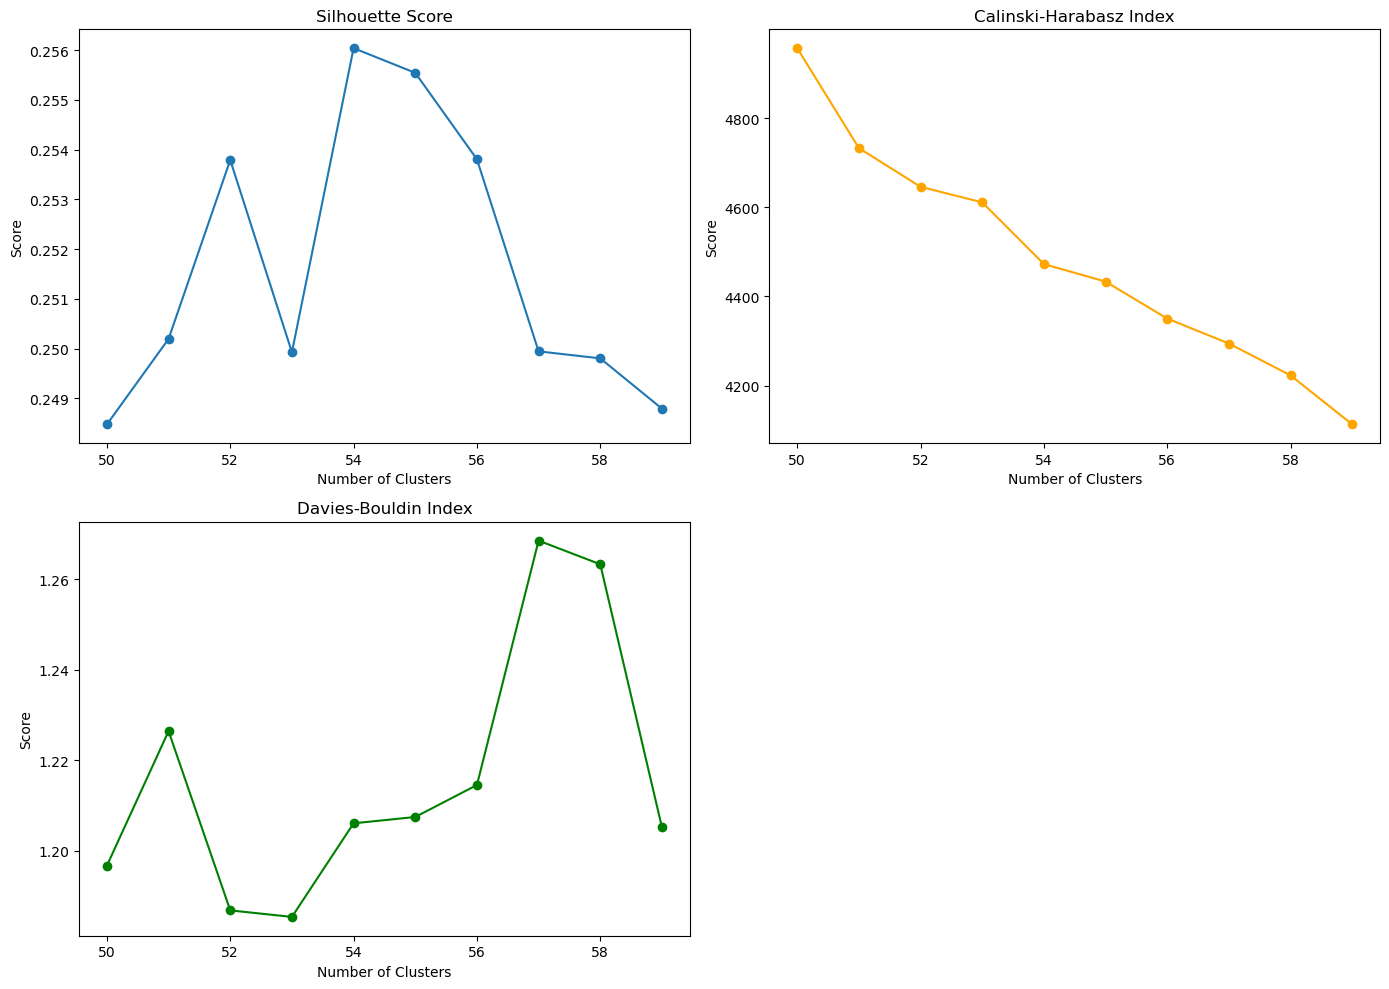

In [469]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn_extra.cluster import KMedoids

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(50,60)

# Step 2: Calculate inertia for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMedoids(n_clusters=n_clusters, random_state=42)
    principal_df['cluster'] = kmeans.fit_predict(principal_df1)
    
    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)


# Now you can plot the results for each index
import matplotlib.pyplot as plt
# Plotting the evaluation metrics
plt.figure(figsize=(14, 10))

# Plotting Silhouette Score
plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()



In [470]:
from sklearn_extra.cluster import KMedoids
kmeans = KMedoids(n_clusters=52, random_state=42)
principal_df['cluster'] = kmeans.fit_predict(principal_df1)

In [471]:
from collections import Counter

cluster_sizes = Counter(principal_df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 250:
        print(f"Cluster {cluster_label} has {size} points")        

Cluster 23 has 392 points
Cluster 43 has 532 points
Cluster 26 has 788 points
Cluster 25 has 883 points
Cluster 18 has 303 points
Cluster 19 has 415 points
Cluster 47 has 666 points
Cluster 14 has 463 points
Cluster 36 has 287 points
Cluster 41 has 9 points
Cluster 24 has 324 points


In [472]:
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.2537924616899232
4645.902788430557
1.1868283082546869


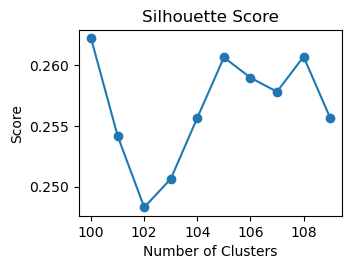

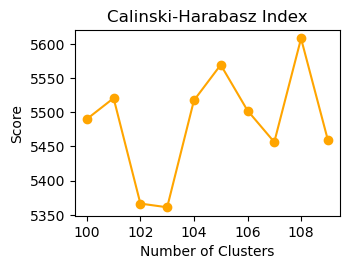

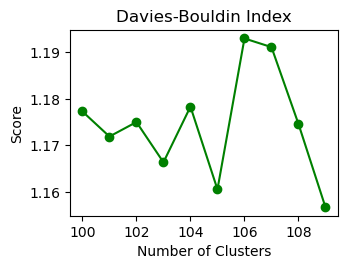

In [492]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(100,110)

for n_clusters in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, random_state=42)
    principal_df['cluster'] = kmeans.fit_predict(principal_df1)
    
    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)


import matplotlib.pyplot as plt


plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [493]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=108, batch_size=100, random_state=42)
principal_df['cluster'] = kmeans.fit_predict(principal_df1)

In [494]:
from collections import Counter

cluster_sizes = Counter(principal_df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 250:
        print(f"Cluster {cluster_label} has {size} points")  

In [495]:
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.2606855589513191
5607.860306532306
1.1746126126796725


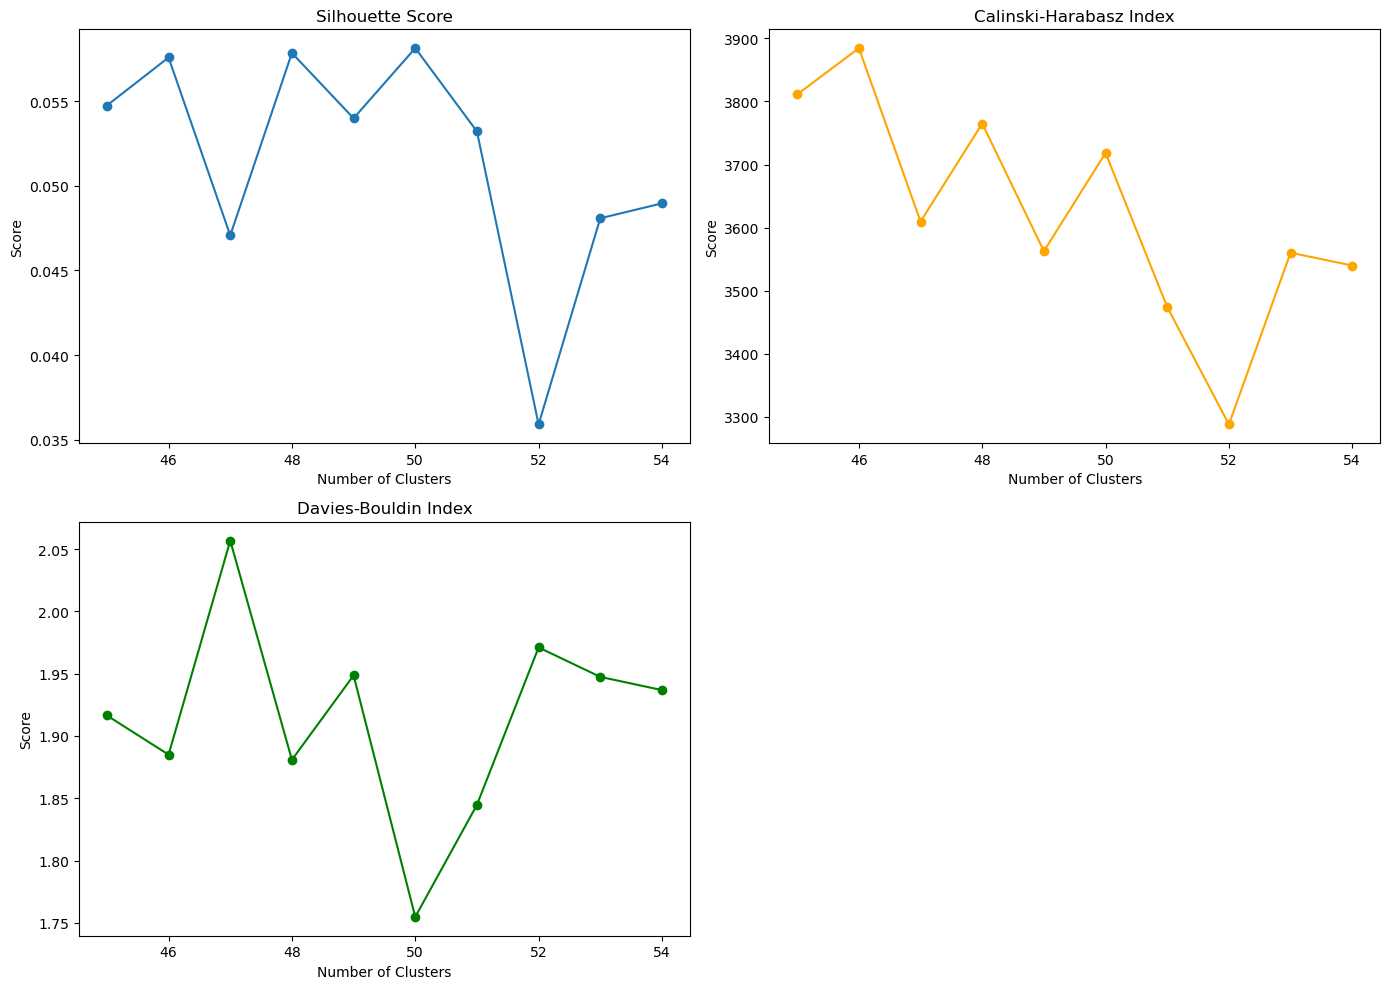

In [231]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming 'principal_df' is your DataFrame with features
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(45,55)

for n_clusters in cluster_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    principal_df['cluster'] = gmm.fit_predict(principal_df1)

    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)

# Plotting the evaluation metrics
plt.figure(figsize=(14, 10))

# Plotting Silhouette Score
plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [539]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=50, random_state=42)
principal_df['cluster'] = gmm.fit_predict(principal_df1)

In [540]:
from collections import Counter

cluster_sizes = Counter(principal_df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 250:
        print(f"Cluster {cluster_label} has {size} points") 

Cluster 10 has 319 points
Cluster 33 has 290 points
Cluster 43 has 364 points
Cluster 48 has 353 points
Cluster 16 has 311 points
Cluster 12 has 405 points
Cluster 19 has 284 points
Cluster 7 has 283 points
Cluster 37 has 288 points


In [541]:
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.058129209600561435
3718.473245259281
1.7547100921298984


In [206]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)  # Convert 'features' column to list before scaling

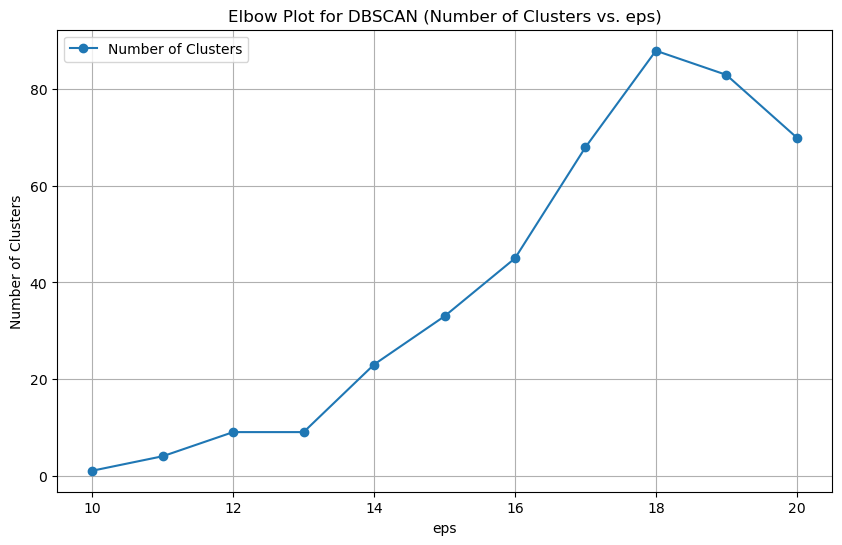

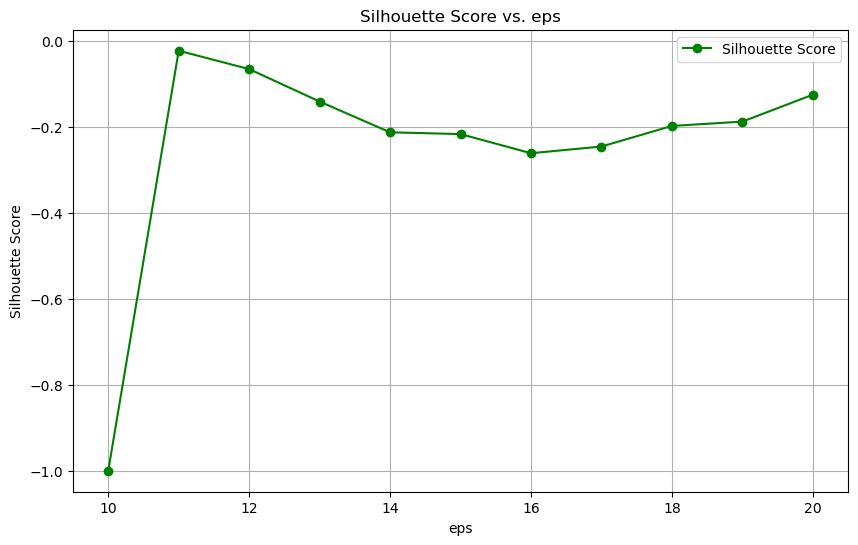

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


eps_values = np.arange(10, 21, 1)

# Initialize lists to store results
num_clusters = []
silhouette_scores = []

for eps in eps_values:
    # Fit DBSCAN model with the current eps
    dbscan = DBSCAN(eps=eps, min_samples=5)
    df['cluster'] = dbscan.fit_predict(scaled_features)
    labels = df['cluster']
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(n_clusters)
    if n_clusters > 1:
        sil_score = silhouette_score(scaled_features, df['cluster'])
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(-1)

        # Plot the number of clusters vs. eps (Elbow plot)
plt.figure(figsize=(10, 6))
plt.plot(eps_values, num_clusters, marker='o', label='Number of Clusters')
plt.title('Elbow Plot for DBSCAN (Number of Clusters vs. eps)')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

# Plot the silhouette score vs. eps
plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_scores, marker='o', color='green', label='Silhouette Score')
plt.title('Silhouette Score vs. eps')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()
plt.show()

In [208]:
# Apply DBSCAN with eps = 18
dbscan = DBSCAN(eps=18, min_samples=5)
df['cluster'] = dbscan.fit_predict(scaled_features)

# Check the cluster labels (number of samples in each cluster)
print(df['cluster'].value_counts())

cluster
-1     4640
 0     1990
 46     903
 20      66
 8       60
       ... 
 1        5
 84       5
 60       4
 56       4
 41       4
Name: count, Length: 88, dtype: int64


In [200]:
print(silhouette_score(df, df['cluster']))
print(calinski_harabasz_score(df, df['cluster']))
print(davies_bouldin_score(df, df['cluster']))

-0.5776343578380586
34.63315119495593
2.7895342863058983


In [232]:
from sklearn.cluster import AffinityPropagation

# Create an AffinityPropagation object
af = AffinityPropagation(damping=0.9)

# Fit the model to the data
af.fit(principal_df1)

# Add the cluster labels to your DataFrame
principal_df['cluster'] = af.labels_

In [233]:
print(principal_df['cluster'].value_counts())

cluster
7     278
12    222
8     212
13    188
1     184
     ... 
2      19
78     15
23     12
61      7
0       6
Name: count, Length: 80, dtype: int64


In [234]:
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.24311034267376733
6812.377824662524
1.186824636740305


In [523]:
from sklearn.cluster import Birch

# Create a Birch object
brc = Birch(threshold=0.3, n_clusters= 80)

# Fit the model to the data
brc.fit(scaled_features)

# Add the cluster labels to your DataFrame
df['cluster'] = brc.labels_

In [524]:
from collections import Counter

cluster_sizes = Counter(df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 250:
        print(f"Cluster {cluster_label} has {size} points") 

Cluster 11 has 303 points
Cluster 4 has 270 points
Cluster 78 has 4 points
Cluster 24 has 264 points


In [525]:
print(silhouette_score(df, df['cluster']))
print(calinski_harabasz_score(df, df['cluster']))
print(davies_bouldin_score(df, df['cluster']))

-0.14954452676826066
348.29121408665725
4.4428252143255715


In [515]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(data_frame, sample_size):
    """
    Calculate the Hopkins statistic to assess the clustering tendency of a dataset.
    
    Parameters:
    - data_frame: pandas DataFrame with the data points
    - sample_size: the number of points to randomly sample for calculating the statistic
    
    Returns:
    - hopkins_stat: float, Hopkins statistic (between 0 and 1)
    """
    # Convert the DataFrame to a NumPy array
    data = data_frame.values
    n, d = data.shape
    
    # Ensure sample_size is not larger than the dataset size
    if sample_size > n:
        sample_size = n
    
    # Randomly select `sample_size` points from the dataset
    np.random.seed(42)  # For reproducibility
    random_sample_indices = np.random.choice(n, sample_size, replace=False)
    random_sample = data[random_sample_indices]
    
    # Generate uniform random points within the range of each feature
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    random_points = np.random.uniform(min_vals, max_vals, (sample_size, d))
    
    # Fit nearest neighbors on the dataset
    nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    
    # Calculate distances from real sample points to their nearest neighbor in the dataset
    u_distances, _ = nbrs.kneighbors(random_sample)
    u_sum = np.sum(u_distances[:, 1])  # Exclude the point itself (0 distance to itself)
    
    # Calculate distances from random points to their nearest neighbor in the dataset
    w_distances, _ = nbrs.kneighbors(random_points)
    w_sum = np.sum(w_distances[:, 0])
    
    # Calculate the Hopkins statistic
    hopkins_stat = w_sum / (u_sum + w_sum)
    
    return hopkins_stat

# Usage
hopkins_value = hopkins_statistic(df1,300)
print(f"Hopkins Statistic: {hopkins_value}")


Hopkins Statistic: 0.819448194097382
